# Model Scoring

This notebook demonstrates how to load a trained model and score new data.

## Prerequisites
- Run `01_training_pipeline.ipynb` first to train and save the model

In [1]:
import numpy as np
import pandas as pd

from src.scoring import Scorer
from src.data import DataLoader

## 1. Load Scorer

In [2]:
# Load the trained model
scorer = Scorer('./artifacts')
scorer.load()

print(f'Loaded model with {len(scorer.get_features())} features')
print(f'Features: {scorer.get_features()[:10]}...')

Loaded model with 8 features
Features: ['credit_score', 'debt_ratio', 'num_accounts', 'age', 'employment_years', 'income', 'region', 'product_type']...


## 2. View Model Metrics

In [3]:
# Get training metrics
metrics = scorer.get_metrics()

print('=== Training Metrics ===')
for split, split_metrics in metrics.items():
    gini = split_metrics.get('gini', 0)
    auc = split_metrics.get('auc', 0)
    print(f'{split}: Gini={gini:.4f}, AUC={auc:.4f}')

=== Training Metrics ===
train: Gini=0.5385, AUC=0.7692
valid: Gini=0.5303, AUC=0.7652
oos: Gini=0.5515, AUC=0.7757
oot: Gini=0.5476, AUC=0.7738


## 3. Prepare New Data

In [4]:
# Option 1: Load from parquet
# loader = DataLoader()
# new_data = loader.load_parquet('/path/to/new_data.parquet')

# Option 2: Create sample new data
np.random.seed(123)
n_new = 1000

new_data = pd.DataFrame({
    'client_id': range(n_new),
    'application_id': range(10000, 10000 + n_new),
    'report_date': pd.date_range('2024-07-01', periods=n_new, freq='h'),
    'product_type': np.random.choice(['PK', 'KK', 'IK'], size=n_new),
    'income': np.random.lognormal(10, 1, n_new),
    'age': np.random.randint(18, 70, n_new),
    'credit_score': np.random.randint(300, 850, n_new),
    'debt_ratio': np.random.uniform(0, 1, n_new),
    'num_accounts': np.random.randint(0, 10, n_new),
    'employment_years': np.random.exponential(5, n_new),
    'region': np.random.choice(['Moscow', 'SPB', 'Other'], size=n_new),
})

print(f'New data shape: {new_data.shape}')
new_data.head()

New data shape: (1000, 11)


,client_id,application_id,report_date,product_type,income,age,credit_score,debt_ratio,num_accounts,employment_years,region
0,0,10000,2024-07-01 00:00:00,IK,14875.085290,61,509,0.140048,4,21.505130,SPB
1,1,10001,2024-07-01 01:00:00,KK,6935.058034,66,799,0.972674,6,0.899657,Moscow
2,2,10002,2024-07-01 02:00:00,IK,25765.141579,51,722,0.355739,4,2.379802,SPB
3,3,10003,2024-07-01 03:00:00,IK,91991.981737,28,479,0.789870,6,7.668808,Other
4,4,10004,2024-07-01 04:00:00,PK,5468.493362,52,810,0.828679,4,5.305885,Moscow


## 4. Score New Data

In [5]:
# Get probability scores
scores = scorer.score(new_data)

print(f'Scores shape: {scores.shape}')
print(f'Score statistics:')
print(f'  Mean: {scores.mean():.4f}')
print(f'  Std:  {scores.std():.4f}')
print(f'  Min:  {scores.min():.4f}')
print(f'  Max:  {scores.max():.4f}')

Scores shape: (1000,)
Score statistics:
  Mean: 0.1826
  Std:  0.0381
  Min:  0.0985
  Max:  0.3048


In [6]:
# Score with details (includes IDs)
result_df = scorer.score_with_details(new_data)

print('Result with details:')
result_df.head(10)

Result with details:


,client_id,application_id,score
0,0,10000,0.156461
1,1,10001,0.173389
2,2,10002,0.140748
3,3,10003,0.249388
4,4,10004,0.157437
5,5,10005,0.167405
6,6,10006,0.174690
7,7,10007,0.120785
8,8,10008,0.129784
9,9,10009,0.206649


## 5. Score Distribution

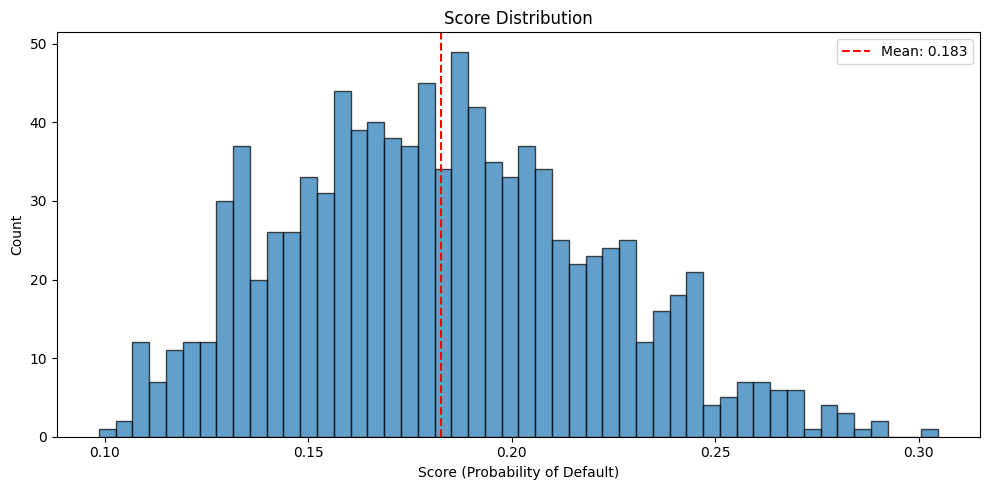

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(scores, bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('Score (Probability of Default)')
ax.set_ylabel('Count')
ax.set_title('Score Distribution')
ax.axvline(scores.mean(), color='red', linestyle='--', label=f'Mean: {scores.mean():.3f}')
ax.legend()
plt.tight_layout()
plt.show()

## 6. Feature Importance

In [8]:
# Get feature importance from the loaded model
importance_df = scorer.get_feature_importance()

print('Top 10 Most Important Features:')
importance_df.head(10)

Top 10 Most Important Features:


,feature,importance
0,credit_score,None
1,debt_ratio,None
2,num_accounts,None
3,age,None
4,employment_years,None
5,income,None
6,region,None
7,product_type,None


## 7. Batch Scoring

In [9]:
def batch_score(scorer, df, batch_size=10000):
    '''
    Score data in batches for large datasets.
    
    Args:
        scorer: Loaded Scorer instance
        df: DataFrame to score
        batch_size: Number of rows per batch
        
    Returns:
        Array of scores
    '''
    all_scores = []
    
    for start in range(0, len(df), batch_size):
        end = min(start + batch_size, len(df))
        batch = df.iloc[start:end]
        batch_scores = scorer.score(batch)
        all_scores.append(batch_scores)
        
        print(f'Scored batch {start}-{end} ({len(batch_scores)} rows)')
    
    return np.concatenate(all_scores)

# Example usage for large dataset
# large_scores = batch_score(scorer, large_df, batch_size=50000)

## 8. Save Scores

In [10]:
# Add scores to the original DataFrame
new_data_scored = new_data.copy()
new_data_scored['pd_score'] = scores

# Save to parquet
# new_data_scored.to_parquet('./scored_data.parquet', index=False)

print('Scored data sample:')
new_data_scored[['client_id', 'application_id', 'pd_score']].head(10)

Scored data sample:


,client_id,application_id,pd_score
0,0,10000,0.156461
1,1,10001,0.173389
2,2,10002,0.140748
3,3,10003,0.249388
4,4,10004,0.157437
5,5,10005,0.167405
6,6,10006,0.174690
7,7,10007,0.120785
8,8,10008,0.129784
9,9,10009,0.206649
